## Al analizar los datos se encontraron datos(imágenes) en la categoría de TV que no coincidian con imágenes de televisores, se realizó una limpieza manual de estos datos ya que al ser un dataset pequeño se podía realizar.

In [ ]:
!pip install rarfile
import rarfile

ruta_rar = "/content/ecommerce products.rar"
ruta_destino = "/content/"

rf = rarfile.RarFile(ruta_rar)
rf.extractall(ruta_destino)


In [ ]:
import cv2
import os


jeans_dir = os.listdir('ecommerce products/jeans')
sofa_dir = os.listdir('ecommerce products/sofa')
tshirt_dir = os.listdir('ecommerce products/tshirt')
tv_dir = os.listdir('ecommerce products/tv')

print(len(jeans_dir), len(sofa_dir), len(tshirt_dir), len(tv_dir))

199 199 199 199



Leyendo imágenes de la categoría: jeans


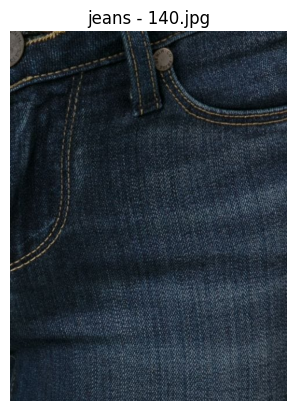


Leyendo imágenes de la categoría: tv


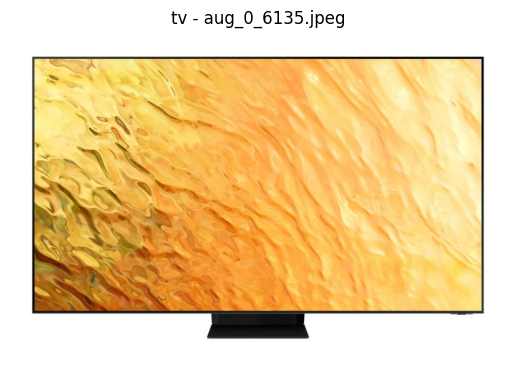


Leyendo imágenes de la categoría: sofa


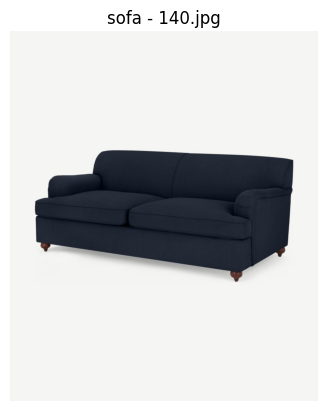


Leyendo imágenes de la categoría: tshirt


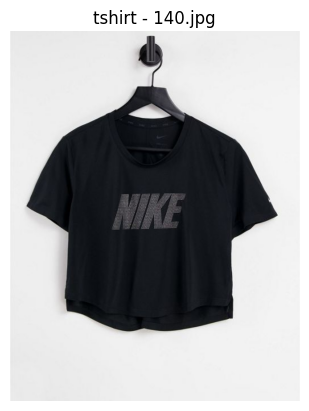

In [ ]:
import matplotlib.pyplot as plt

# Ruta base
base_path = "ecommerce products"

# Extensiones de imágenes soportadas
image_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".tiff"}

dic = {}
# Recorrer las carpetas dentro de "ecommerce products"
for category in os.listdir(base_path):
    category_path = os.path.join(base_path, category)
    lis_imgs=[]
    # Verificar si es un directorio
    if os.path.isdir(category_path):
        print(f"\nLeyendo imágenes de la categoría: {category}")

        # Recorrer los archivos en cada subcarpeta
        for file in os.listdir(category_path):
            file_path = os.path.join(category_path, file)

            # Verificar si el archivo es una imagen
            if os.path.isfile(file_path) and any(file.lower().endswith(ext) for ext in image_extensions):
                # Leer la imagen con OpenCV
                image = cv2.imread(file_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB para matplotlib
                lis_imgs.append(image)

                # Mostrar la imagen
    plt.imshow(lis_imgs[0])
    plt.title(f"{category} - {file}")
    plt.axis("off")
    plt.show()
    dic[category] = lis_imgs.copy()




In [ ]:
print(dic.keys())

print(list(map(len, dic.values())))

dict_keys(['jeans', 'tv', 'sofa', 'tshirt'])
[199, 199, 199, 199]


En la impresión anterior se evidencia que las imágenes no poseen el mismo tamaño, por lo que se disminuirá el tamaño de todas las imágenes a 150x150 pixeles

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os
import numpy as np

# Configurar el data augmentation con los parámetros deseados
datagen = ImageDataGenerator(
    rotation_range=20,         # Rotación aleatoria de 0 a 20 grados
    width_shift_range=0.2,     # Traslación horizontal
    height_shift_range=0.2,    # Traslación vertical
    shear_range=0.2,           # Cizallamiento
    zoom_range=0.2,            # Zoom aleatorio
    horizontal_flip=True,      # Volteo horizontal
    fill_mode='nearest'        # Cómo rellenar los pixeles vacíos
)

# Rutas a la carpeta con las imágenes de la clase con 154 datos y a la carpeta destino para guardar las imágenes aumentadas
input_folder = 'ecommerce products/tv'
output_folder = 'ecommerce products/tv'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Calcular cuántas imágenes adicionales necesitamos generar
num_imagenes = len(os.listdir(input_folder))
objetivo = 199  # Número de imágenes que queremos alcanzar para balancear el dataset
num_a_generar = objetivo - num_imagenes

print(f"Generando {num_a_generar} imágenes nuevas para balancear la clase...")

# Generar imágenes aumentadas a partir de cada imagen de la clase
imagenes_generadas = 0
for filename in os.listdir(input_folder):
    if imagenes_generadas >= num_a_generar:
        break

    ruta_imagen = os.path.join(input_folder, filename)
    imagen = load_img(ruta_imagen)  # Cargar la imagen
    x = img_to_array(imagen)        # Convertir a array
    x = x.reshape((1,) + x.shape)   # Redimensionar a 4D para el generador

    # Generar imágenes nuevas a partir de la imagen actual
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir=output_folder,
                              save_prefix='aug',
                              save_format='jpeg'):
        i += 1
        imagenes_generadas += 1
        if i >= 1 or imagenes_generadas >= num_a_generar:
            # Generamos 1 imagen por archivo o detenemos si ya alcanzamos el objetivo
            break


Generando 0 imágenes nuevas para balancear la clase...


In [ ]:
jeans_dir = os.listdir('ecommerce products/jeans')
sofa_dir = os.listdir('ecommerce products/sofa')
tshirt_dir = os.listdir('ecommerce products/tshirt')
tv_dir = os.listdir('ecommerce products/tv')
print(len(jeans_dir), len(sofa_dir), len(tshirt_dir), len(tv_dir))

199 199 199 199


# En algunos casos es bueno convertir las imágenes a una sola dimensión de color(grises) para disminuir la dimensionalidad del problema y la carga computacional de entrenamiento, pero en este caso se cuentan con poicos datos de entrenamiento por lo que se pueden conservar los tres canales de color, ya que en muchos casos estos pueden aportar información adicional al modelo.

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

learning_rate = 1e-4
# Parámetros del modelo y de las imágenes
img_width, img_height = 150, 150   # Dimensiones a las que se redimensionarán las imágenes
batch_size = 32

# Ruta al dataset (estructura: dataset/clase1, dataset/clase2, etc.)
data_dir = 'ecommerce products'  # Cambia esta ruta por la de tu dataset

# Configuración del data augmentation y división de datos en entrenamiento y validación
datagen = ImageDataGenerator(
    rescale=1./255,            # Normalización de píxeles
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2       # Reserva el 20% de los datos para validación
)

# Generadores de datos para entrenamiento y validación
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Determinar el número de clases automáticamente
num_classes = len(train_generator.class_indices)
print("Número de clases:", num_classes)

# Definir la arquitectura de la red neuronal convolucional
model = Sequential()

# Primera capa de convolución y pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

# Segunda capa de convolución y pooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

# Tercera capa de convolución y pooling
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

# Aplanado y capas densas
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Capa de salida: softmax para clasificación multiclase

# Compilar el modelo
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar un resumen de la arquitectura
model.summary()

# Entrenar el modelo


Found 640 images belonging to 4 classes.
Found 156 images belonging to 4 classes.
Número de clases: 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 74, 74, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 36, 36, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 17, 17, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,036,612 (72.62 MB)

 Trainable params: 19,036,164 (72.62 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:

epochs = 50


history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Guardar el modelo entrenado en h5
model.save('modelo_cnn.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 436ms/step - accuracy: 0.6742 - loss: 1.2014 - val_accuracy: 0.2422 - val_loss: 1.4522
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 679ms/step - accuracy: 0.8555 - loss: 0.6242 - val_accuracy: 0.2656 - val_loss: 1.7129
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 364ms/step - accuracy: 0.9023 - loss: 0.4327 - val_accuracy: 0.2812 - val_loss: 1.9193
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 404ms/step - accuracy: 0.9035 - loss: 0.4077 - val_accuracy: 0.2500 - val_loss: 2.5600
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 404ms/step - accuracy: 0.9224 - loss: 0.4562 - val_accuracy: 0.4375 - val_loss: 2.6657
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 411ms/step - accuracy: 0.9163 - loss: 0.4289 - val_accuracy: 0.4062 - val_loss: 3.5415
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 388ms/step - accuracy: 0.9341 - loss: 0.2296 - val_accuracy: 0.2656 - val_loss: 5.0207
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 380ms/step - accuracy: 0.9515 - loss: 0.2185 - val_accurac

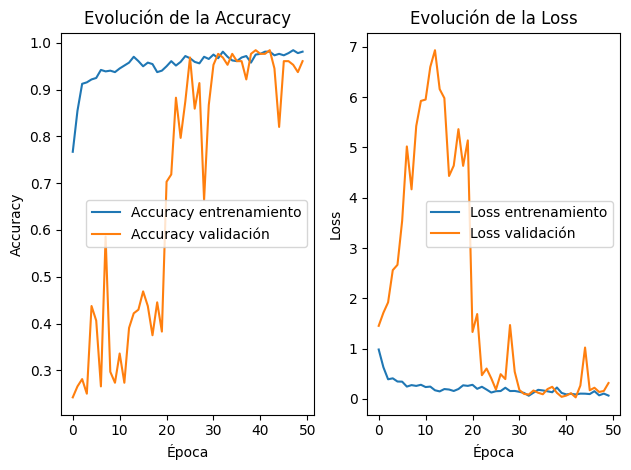

In [ ]:
# Gráfico de Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy validación')
plt.title('Evolución de la Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

# Gráfico de Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss entrenamiento')
plt.plot(history.history['val_loss'], label='Loss validación')
plt.title('Evolución de la Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Los saltos en validacion tanto en accuracy como en loss puede deberse a que el conjunto de validación es muy pequeño y pequeñas variaciones en los datos o en el proceso de muestreo pueden ocasionar fluctuaciones grandes en la métrica. Sin embargo se evidencia que en las ultimas epochs el rendimiento se estabiliza.

In [ ]:
 print("Mirar en caso de querer verificar que número se le asignó a cada clase")
 print(train_generator.class_indices)


Mirar en caso de querer verificar que número se le asignó a cada clase
{'jeans': 0, 'sofa': 1, 'tshirt': 2, 'tv': 3}


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

def predecir_imagen_con_umbral(ruta_imagen, model, img_width, img_height, class_indices, umbral=0.88):
    """
    Predice la clase de una imagen externa y verifica si la predicción supera un umbral de confianza.

    Parámetros:
      - ruta_imagen: Ruta de la imagen a predecir.
      - model: Modelo entrenado.
      - img_width, img_height: Dimensiones de la imagen (deben coincidir con las usadas en entrenamiento).
      - class_indices: Diccionario mapeando nombres de clase a índices, util porque se obtiene del generador.
      - umbral: Valor mínimo de confianza para aceptar una predicción.

    Retorna:
      - etiqueta: La etiqueta predicha o 'Desconocido' si la confianza es baja.
    """
    # Cargar y preprocesar la imagen
    imagen = load_img(ruta_imagen, target_size=(img_width, img_height))
    imagen = img_to_array(imagen) / 255.0
    imagen = np.expand_dims(imagen, axis=0)

    # Realizar la predicción
    prediccion = model.predict(imagen)
    max_prob = np.max(prediccion)

    # Imprimir información para depurar
    #print("Predicción:", prediccion)
    print("Probabilidad máxima:", max_prob)

    # Si la probabilidad máxima es menor al umbral, se clasifica como desconocido
    if max_prob < umbral:
        return "Desconocido"
    else:
        indice_clase = np.argmax(prediccion)
        # Invertir el diccionario para mapear índice -> etiqueta
        class_labels = {v: k for k, v in class_indices.items()}
        etiqueta = class_labels[indice_clase]
        return etiqueta




In [ ]:
def predecir_imagenes(iter_imag, imprimir=True):
    """Recibe un iterable con las imágenes, imprime que clase
        predicha si se pasa el parametro imprimir en True y retorna
        una lista con las clases predichas.
    """
    preds = []
    if imprimir:
        for i in (iter_imag):
            pred = predecir_imagen_con_umbral(i, model, img_width, img_height, train_generator.class_indices, umbral=0.88)
            print(f"La imagen {i} pertenece a la clase: {pred}")
            preds.append(pred)
    else:
        for i in (iter_imag):
            pred = predecir_imagen_con_umbral(i, model, img_width, img_height, train_generator.class_indices, umbral=0.88)
            preds.append(pred)



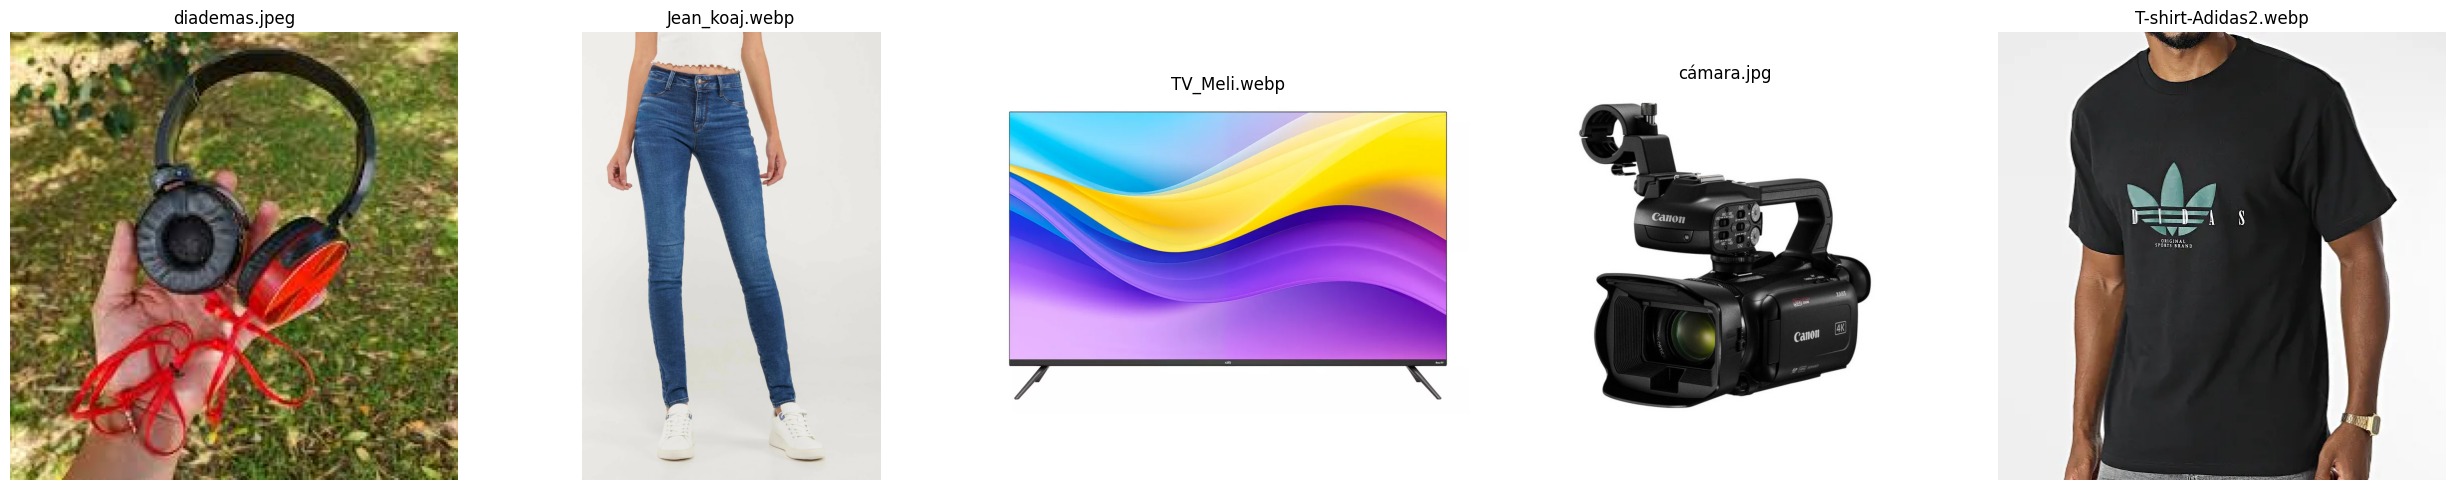

In [ ]:
import matplotlib.image as mpimg

def graficar_imagenes(rutas):
    num_imagenes = len(rutas)
    # Configuramos la figura; aquí se muestra en una sola fila.
    fig, axs = plt.subplots(1, num_imagenes, figsize=(5 * num_imagenes, 5))

    # Si solo hay una imagen, convertimos axs en una lista para iterar
    if num_imagenes == 1:
        axs = [axs]

    for ax, ruta in zip(axs, rutas):
        # Cargamos la imagen
        imagen = mpimg.imread(ruta)
        # Mostramos la imagen
        ax.imshow(imagen)
        # Eliminamos los ejes para una visualización más limpia
        ax.axis('off')
        # Opcional: mostrar el nombre del archivo como título
        ax.set_title(ruta.split('/')[-1])

    plt.tight_layout()
    plt.show()


rutas_imagenes = ['/content/diademas.jpeg', '/content/Jean_koaj.webp',
                  '/content/TV_Meli.webp', '/content/cámara.jpg',
                  '/content/T-shirt-Adidas2.webp']
graficar_imagenes(rutas_imagenes)


In [ ]:
predecir_imagenes(rutas_imagenes, imprimir=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Probabilidad máxima: 0.85527515
La imagen /content/diademas.jpeg pertenece a la clase: Desconocido
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Probabilidad máxima: 0.97123295
La imagen /content/Jean_koaj.webp pertenece a la clase: jeans
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Probabilidad máxima: 1.0
La imagen /content/TV_Meli.webp pertenece a la clase: tv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Probabilidad máxima: 1.0
La imagen /content/cámara.jpg pertenece a la clase: tv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Probabilidad máxima: 0.9972377
La imagen /content/Cepillo_Electrico.webp pertenece a la clase: tshirt
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Probabilidad máxima: 0.9959793
La imagen /content/t-shirt_adidas_black.webp pertenece a la clase: tv


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


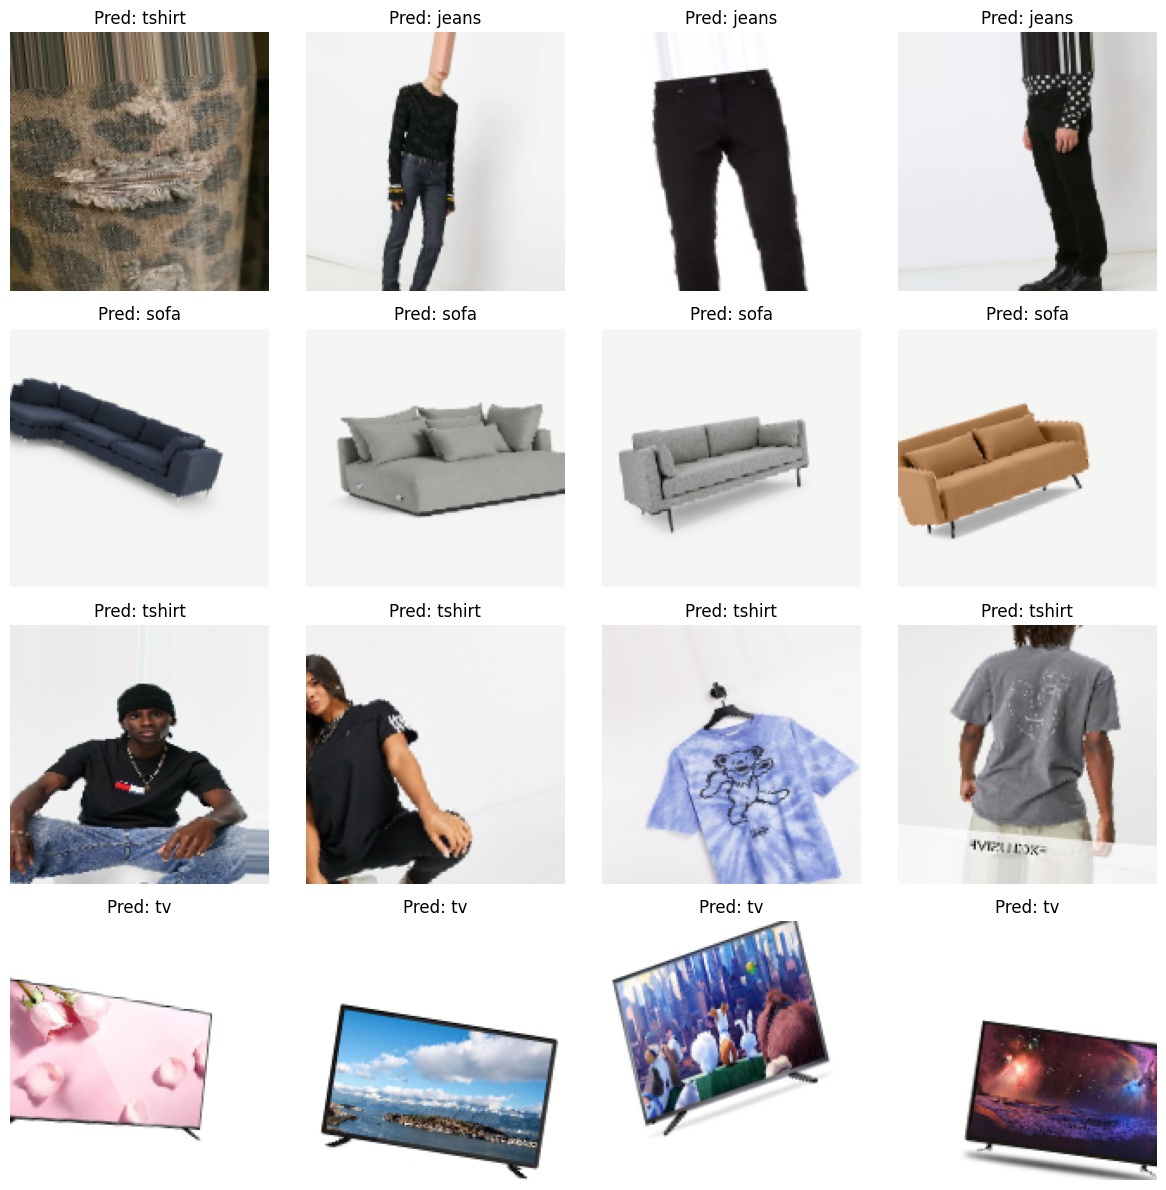

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_por_clase(validation_generator, images_per_class=4, model=None):
    """
    Extrae y grafica 'images_per_class' imágenes de cada clase del generador de validación.
    Si se proporciona un modelo, también muestra la clase predicha para cada imagen.

    Parámetros:
      - validation_generator: generador creado con flow_from_directory (con subset='validation').
      - images_per_class: número de imágenes a mostrar por cada clase (por defecto 4).
      - model: modelo de Keras para realizar predicciones. Si se proporciona, se añadirá
               la etiqueta predicha a cada imagen.
    """
    # Obtener el mapeo de clases (nombre -> índice) e invertirlo (índice -> nombre)
    class_indices = validation_generator.class_indices
    index_to_class = {v: k for k, v in class_indices.items()}

    # Diccionario para almacenar imágenes por clase
    images_by_class = {i: [] for i in index_to_class.keys()}

    # Extraer imágenes hasta tener 'images_per_class' por cada clase
    while any(len(images_by_class[i]) < images_per_class for i in images_by_class):
        X_batch, y_batch = next(validation_generator)
        for img, label in zip(X_batch, y_batch):
            class_index = label.argmax()  # Suponiendo codificación one-hot
            if len(images_by_class[class_index]) < images_per_class:
                images_by_class[class_index].append(img)

    num_classes = len(images_by_class)
    # Crear figura y ejes para la cuadrícula
    fig, axs = plt.subplots(num_classes, images_per_class, figsize=(images_per_class * 3, num_classes * 3))

    # Asegurarse de que axs sea una matriz 2D, incluso si hay solo una fila
    if num_classes == 1:
        axs = np.expand_dims(axs, axis=0)

    # Iterar por cada clase y cada imagen
    for i, class_index in enumerate(sorted(images_by_class.keys())):
        true_class_name = index_to_class[class_index]
        for j in range(images_per_class):
            ax = axs[i, j]
            img = images_by_class[class_index][j]
            ax.imshow(img)
            ax.axis('off')

            # Si se proporciona un modelo, realizar la predicción
            if model is not None:
                # Agregar dimensión de batch
                img_input = np.expand_dims(img, axis=0)
                pred = model.predict(img_input)
                predicted_index = pred.argmax(axis=1)[0]
                predicted_class = index_to_class[predicted_index]
                ax.set_title(f"Pred: {predicted_class}", fontsize=12)
            else:
                ax.set_title("Sin predicción", fontsize=12)

            # Mostrar la etiqueta verdadera en el primer gráfico de cada fila
            if j == 0:
                ax.set_ylabel(f"Real: {true_class_name}", fontsize=14)

    plt.tight_layout()
    plt.show()

plot_images_por_clase(validation_generator, images_per_class=4, model=model)


## El modelo presenta un buen rendimiento como lo se puede apreciar en los datos de validacion y en los datos que se utilizaron como prueba desde internet. El modelo no siempre predice bien la clase desconocida pero es debido a que los televisores y las camisas tienen patrones de objetos, lo que hace que el modelo asimile esos patrones con las clases TV y T-shirt, por lo que umbralizar se vuelve difícil ya que se tendría que usar un umbral muy agresivo

## Guardar el modelo en un .pkl

In [ ]:
import pickle

# Serializar la arquitectura a JSON y obtener los pesos
modelo_json = model.to_json()
pesos = model.get_weights()

# Crear un diccionario que contenga la arquitectura y los pesos
modelo_serializado = {
    'modelo_json': modelo_json,
    'pesos': pesos
}

# Guardar el diccionario en un archivo .pkl
with open('modelo_cnn.pkl', 'wb') as f:
    pickle.dump(modelo_serializado, f)

print("Modelo guardado en 'modelo_cnn.pkl'")


Modelo guardado en 'modelo_cnn.pkl'


## Leer el modelo en caso de necesitarse

In [ ]:
#from tensorflow.keras.models import model_from_json

# Cargar el diccionario serializado desde el archivo .pkl
#with open('modelo_cnn.pkl', 'rb') as f:
#    modelo_serializado = pickle.load(f)

# Reconstruir la arquitectura a partir del JSON
#modelo_json = modelo_serializado['modelo_json']
#model_cargado = model_from_json(modelo_json)

# Cargar los pesos en el modelo reconstruido
#model_cargado.set_weights(modelo_serializado['pesos'])

# Compilar el modelo si es necesario (usando los mismos hiperparámetros que usaste al entrenarlo)
#from tensorflow.keras.optimizers import Adam
#learning_rate = 1e-4  # Ajusta el learning_rate si es necesario
#model_cargado.compile(optimizer=Adam(learning_rate=learning_rate),
#                      loss='categorical_crossentropy',
#                      metrics=['accuracy'])

#print("Modelo cargado correctamente desde 'modelo_cnn.pkl'")


## Se trató de implementar una arquitectura más sofisticada, pero no se consiguieron mejores resultados con esta, la arquitectura fue la del siguiente bloque de código

In [ ]:
introducir error para parar ejecución. En caso de querer leer, borrar el comentario y ejecutar
# Arquitectura mejorada de la red neuronal convolucional
model = Sequential()

# Bloque 1: 2 capas convolucionales
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Bloque 2: 2 capas convolucionales
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Bloque 3: 2 capas convolucionales
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Bloque 4: Opcional, para extraer características más complejas
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Capa de aplanado y capas densas
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Capa de salida para clasificación multiclase

SyntaxError: invalid syntax (<ipython-input-17-0710c7d101e0>, line 1)